<a href="https://colab.research.google.com/github/Friedrich9999/Regelenergie/blob/main/RegelEnergieProgramm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 📦 1. Imports (no extra install needed)
import requests, datetime, pandas as pd, pathlib, time, io, os


# 📁 2. Create output directory
output_dir = pathlib.Path("netztrans_data")
output_dir.mkdir(exist_ok=True)

# 🔐 3. Authentication
AUTH_URL = "https://identity.netztransparenz.de/users/connect/token"
CLIENT_ID = "cm_app_ntp_id_5af963fb38c34bf2b085967a8a2d46c9"
CLIENT_SECRET = "ntp_YeQSVHclLVlr2j46VA2j"

auth_response = requests.post(
    AUTH_URL,
    data={"grant_type": "client_credentials"},
    auth=(CLIENT_ID, CLIENT_SECRET),
    timeout=30
)

if auth_response.status_code != 200:
    raise Exception(f"❌ Authentication failed: {auth_response.status_code}")

ACCESS_TOKEN = auth_response.json()["access_token"]
headers = {
    "Authorization": f"Bearer {ACCESS_TOKEN}",
    "Accept": "application/json"
}

# 🌐 4. Define API endpoints
BASE = "https://ds.netztransparenz.de/api/v1/data"
ENDPOINTS = {
    "Aktivated_aFRR" : ("nrvsaldo", "AktivierteSRL"),
    "Aktivated_mFRR" : ("nrvsaldo", "AktivierteMRL"),
    "Wind"           : ("hochrechnung", "Wind"),
    "Solar"          : ("hochrechnung", "Solar"),
    "WindForecast"   : ("prognose", "Wind"),
    "SolarForecast"  : ("prognose", "Solar"),
    "reBAP"          : ("nrvsaldo", "reBAP")
}

START = datetime.date(2015, 1, 1)
STOP  = datetime.date.today()
STEP  = datetime.timedelta(days=365)

# 📡 5. Fetch and save function
def fetch_one(name, data, product, start_date, end_date):
    url = f"{BASE}/{data}/{product}/{start_date}/{end_date}"
    print(f"📡 Fetching {name} from {start_date} to {end_date} ...")

    try:
        response = requests.get(url, headers=headers, timeout=60)
        response.raise_for_status()

        if not response.text.strip():
            print(f"⚠️ Empty response from server ({start_date} to {end_date}) — skipped.")
            return

        try:
            parsed_data = json.loads(response.text, parse_constant=lambda x: None)
            df = pd.DataFrame(parsed_data)
        except json.JSONDecodeError as error:
            print(f"❌ JSON parsing error for {name} {start_date} → {end_date}: {error}")
            return

        if df.empty:
            print(f"⚠️ No data for {name} from {start_date} to {end_date}")
            return

        df["timestamp"] = pd.to_datetime(df["timestamp"])
        filename = output_dir / f"{name}_{start_date}_{end_date}.parquet"
        df.to_parquet(filename)
        print(f"✅ Saved to {filename} ({len(df)} rows)")

    except requests.RequestException as error:
        print(f"❌ HTTP error while fetching {name} ({start_date} to {end_date}): {error}")

# 🔁 6. Download loop for each endpoint and year range
for name, (data, product) in ENDPOINTS.items():
    current_start = START
    while current_start < STOP:
        current_end = min(current_start + STEP, STOP)
        fetch_one(name, data, product, current_start, current_end)
        current_start = current_end + datetime.timedelta(days=1)
        time.sleep(0.5)  # respect the server


📡 Fetching Aktivated_aFRR from 2015-01-01 to 2016-01-01 ...


NameError: name 'json' is not defined

In [ ]:
import requests, pandas as pd, json, io

# 1. Authentication
AUTH_URL = "https://identity.netztransparenz.de/users/connect/token"
CLIENT_ID = "cm_app_ntp_id_5af963fb38c34bf2b085967a8a2d46c9"
CLIENT_SECRET = "ntp_YeQSVHclLVlr2j46VA2j"

auth_response = requests.post(
    AUTH_URL,
    data={"grant_type": "client_credentials"},
    auth=(CLIENT_ID, CLIENT_SECRET),
    timeout=30
)

ACCESS_TOKEN = auth_response.json()["access_token"]
headers = {
    "Authorization": f"Bearer {ACCESS_TOKEN}",
    "Accept": "application/json"
}
#print("🔍 Auth response JSON:", auth_response.json())

# 2. Build correct URL
BASE = "https://ds.netztransparenz.de/api/v1/data"
dataType = "Spotmarktpreise"  #Just Spotmarketprice for testing simple but known working api url
product = ""
dateFrom = "2025-01-01T00:00:00"
dateTo = "2025-04-28T23:59:00"

if product == '':
    url = f"{BASE}/{dataType}/{dateFrom}/{dateTo}"
else:
    url = f"{BASE}/{dataType}/{product}/{dateFrom}/{dateTo}"

if dateFrom == '' or dateTo == '':
    url = f"{BASE}/{dataType}/{product}"

print("🔗 URL:", url)

# 3. Request
response = requests.get(url, headers=headers)
print("✅ Status:", response.status_code)
print("📦 First 300 chars:", response.text[:300])

🔗 URL: https://ds.netztransparenz.de/api/v1/data/Spotmarktpreise/2025-01-01T00:00:00/2025-04-28T23:59:00
✅ Status: 200
📦 First 300 chars: "Datum;von;Zeitzone von;bis;Zeitzone bis;Spotmarktpreis in ct/kWh\r\n01.01.2025;00:00;UTC;01:00;UTC;0,160\r\n01.01.2025;01:00;UTC;02:00;UTC;0,000\r\n01.01.2025;02:00;UTC;03:00;UTC;-0,001\r\n01.01.2025;03:00;UTC;04:00;UTC;-0,001\r\n01.01.2025;04:00;UTC;05:00;UTC;-0,006\r\n01.01.2025;05:00;UTC;06:00;U


In [ ]:
import requests
import pandas as pd
import io
from tabulate import tabulate  # pip install tabulate
# 1. Authentication
AUTH_URL = "https://identity.netztransparenz.de/users/connect/token"
CLIENT_ID = "cm_app_ntp_id_5af963fb38c34bf2b085967a8a2d46c9"
CLIENT_SECRET = "ntp_YeQSVHclLVlr2j46VA2j"

auth_response = requests.post(
    AUTH_URL,
    data={"grant_type": "client_credentials"},
    auth=(CLIENT_ID, CLIENT_SECRET),
    timeout=30
)

ACCESS_TOKEN = auth_response.json()["access_token"]
headers = {
    "Authorization": f"Bearer {ACCESS_TOKEN}",
    "Accept": "application/json"
}
#print("🔍 Auth response JSON:", auth_response.json())



# 1. Setup
BASE = "https://ds.netztransparenz.de/api/v1/data"
dataType = "Spotmarktpreise"
product = ""
dateFrom = "2025-01-01T00:00:00"
dateTo = "2025-04-28T23:59:00"

headers = {
    "Authorization": f"Bearer {ACCESS_TOKEN}",
    "Accept": "text/csv"
}

# 2. Build URL
if product == '':
    url = f"{BASE}/{dataType}/{dateFrom}/{dateTo}"
else:
    url = f"{BASE}/{dataType}/{product}/{dateFrom}/{dateTo}"

if dateFrom == '' or dateTo == '':
    url = f"{BASE}/{dataType}/{product}"

print("🔗 URL:", url)

# 3. Request
response = requests.get(url, headers=headers)
print("✅ Status:", response.status_code)
print("📦 First 100 chars:", response.text[:100])

# 4. Parse CSV
content_type = response.headers.get('Content-Type')
print("📄 Content-Type:", content_type)

try:
    df = pd.read_csv(
        io.StringIO(response.text),
        sep=';',
        decimal=',',
        encoding='utf-8'
    )

    df['Spotmarktpreis in ct/kWh'] = pd.to_numeric(df['Spotmarktpreis in ct/kWh'], errors='coerce')
    df['Datum'] = pd.to_datetime(df['Datum'], format='%d.%m.%Y', errors='coerce').dt.strftime('%d.%m.%Y')

    # Optional: Filter and rename columns for display
    display_df = df[['Datum', 'von', 'bis', 'Spotmarktpreis in ct/kWh']].copy()
    display_df.columns = ['Datum', 'von', 'bis', 'Spotpreis (ct/kWh)']

    print("\n📊 Strombörse Spotmarktpreise:")
    print(tabulate(display_df.head(49), headers='keys', tablefmt='github'))  # Only first 20 rows
except Exception as e:
    print(f"❌ Failed to parse CSV data: {e}")

🔗 URL: https://ds.netztransparenz.de/api/v1/data/Spotmarktpreise/2025-01-01T00:00:00/2025-04-28T23:59:00
✅ Status: 200
📦 First 100 chars: Datum;von;Zeitzone von;bis;Zeitzone bis;Spotmarktpreis in ct/kWh
01.01.2025;00:00;UTC;01:00;UTC;0,1
📄 Content-Type: text/plain; charset=utf-8

📊 Strombörse Spotmarktpreise:
|    | Datum      | von   | bis   |   Spotpreis (ct/kWh) |
|----|------------|-------|-------|----------------------|
|  0 | 01.01.2025 | 00:00 | 01:00 |                0.16  |
|  1 | 01.01.2025 | 01:00 | 02:00 |                0     |
|  2 | 01.01.2025 | 02:00 | 03:00 |               -0.001 |
|  3 | 01.01.2025 | 03:00 | 04:00 |               -0.001 |
|  4 | 01.01.2025 | 04:00 | 05:00 |               -0.006 |
|  5 | 01.01.2025 | 05:00 | 06:00 |               -0.009 |
|  6 | 01.01.2025 | 06:00 | 07:00 |               -0.001 |
|  7 | 01.01.2025 | 07:00 | 08:00 |               -0.001 |
|  8 | 01.01.2025 | 08:00 | 09:00 |               -0.004 |
|  9 | 01.01.2025 | 09:00 | 10:00 |     

🔗 URL: https://ds.netztransparenz.de/api/v1/data/Spotmarktpreise/2025-01-01T00:00:00/2025-04-28T23:59:00
✅ Status: 200
📦 First 100 chars: Datum;von;Zeitzone von;bis;Zeitzone bis;Spotmarktpreis in ct/kWh
01.01.2025;00:00;UTC;01:00;UTC;0,1
📄 Content-Type: text/plain; charset=utf-8

📊 Strombörse Spotmarktpreise:
|    | Datum      | von   | bis   |   Spotpreis (ct/kWh) |
|----|------------|-------|-------|----------------------|
|  0 | 01.01.2025 | 00:00 | 01:00 |                0.16  |
|  1 | 01.01.2025 | 01:00 | 02:00 |                0     |
|  2 | 01.01.2025 | 02:00 | 03:00 |               -0.001 |
|  3 | 01.01.2025 | 03:00 | 04:00 |               -0.001 |
|  4 | 01.01.2025 | 04:00 | 05:00 |               -0.006 |
|  5 | 01.01.2025 | 05:00 | 06:00 |               -0.009 |
|  6 | 01.01.2025 | 06:00 | 07:00 |               -0.001 |
|  7 | 01.01.2025 | 07:00 | 08:00 |               -0.001 |
|  8 | 01.01.2025 | 08:00 | 09:00 |               -0.004 |
|  9 | 01.01.2025 | 09:00 | 10:00 |     

KeyboardInterrupt: 

/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


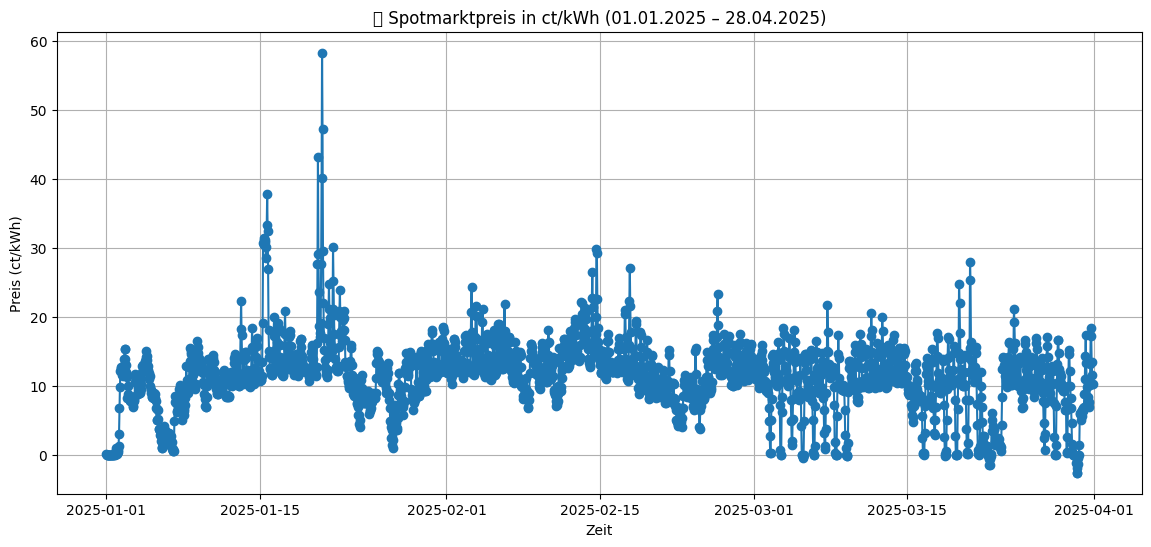

In [ ]:
import requests
import pandas as pd
import io
from tabulate import tabulate
import matplotlib.pyplot as plt

# 1. Authentication
AUTH_URL = "https://identity.netztransparenz.de/users/connect/token"
CLIENT_ID = "cm_app_ntp_id_5af963fb38c34bf2b085967a8a2d46c9"
CLIENT_SECRET = "ntp_YeQSVHclLVlr2j46VA2j"

auth_response = requests.post(
    AUTH_URL,
    data={"grant_type": "client_credentials"},
    auth=(CLIENT_ID, CLIENT_SECRET),
    timeout=30
)

ACCESS_TOKEN = auth_response.json().get("access_token")
if not ACCESS_TOKEN:
    raise Exception("❌ Authentication failed. No access token received.")

# 2. Build URL
BASE = "https://ds.netztransparenz.de/api/v1/data"
dataType = "Spotmarktpreise"
product = ""
dateFrom = "2025-01-01T00:00:00"
dateTo = "2025-04-28T23:59:00"

if product == '':
    url = f"{BASE}/{dataType}/{dateFrom}/{dateTo}"
else:
    url = f"{BASE}/{dataType}/{product}/{dateFrom}/{dateTo}"

headers = {
    "Authorization": f"Bearer {ACCESS_TOKEN}",
    "Accept": "text/csv"
}

print("🔗 URL:", url)

# 3. Request
response = requests.get(url, headers=headers)
print("✅ Status:", response.status_code)
print("📦 First 100 chars:", response.text[:100])

# 4. Parse CSV
content_type = response.headers.get('Content-Type')
print("📄 Content-Type:", content_type)

try:
    df = pd.read_csv(
        io.StringIO(response.text),
        sep=';',
        decimal=',',
        encoding='utf-8'
    )

    df['Spotmarktpreis in ct/kWh'] = pd.to_numeric(df['Spotmarktpreis in ct/kWh'], errors='coerce')
    df['Datum'] = pd.to_datetime(df['Datum'], format='%d.%m.%Y', errors='coerce').dt.strftime('%d.%m.%Y')

    # Optional: Filter and rename columns for display
    display_df = df[['Datum', 'von', 'bis', 'Spotmarktpreis in ct/kWh']].copy()
    display_df.columns = ['Datum', 'von', 'bis', 'Spotpreis (ct/kWh)']

    print("\n📊 Strombörse Spotmarktpreise:")
    print(tabulate(display_df.head(24), headers='keys', tablefmt='github'))  # Show first 20 rows

    # 5. Plotting
    df['Startzeit'] = pd.to_datetime(df['Datum'] + ' ' + df['von'], format='%d.%m.%Y %H:%M')
    plt.figure(figsize=(14, 6))
    plt.plot(df['Startzeit'], df['Spotmarktpreis in ct/kWh'], marker='o', linestyle='-')
    plt.title('📈 Spotmarktpreis in ct/kWh (01.01.2025 – 28.04.2025)')
    plt.xlabel('Zeit')
    plt.ylabel('Preis (ct/kWh)')
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.show()

except Exception as e:
    print(f"❌ Failed to parse CSV data or plot: {e}")


In [ ]:
import requests, pandas as pd, json, io

# 1. Authentication
AUTH_URL = "https://identity.netztransparenz.de/users/connect/token"
CLIENT_ID = "cm_app_ntp_id_5af963fb38c34bf2b085967a8a2d46c9"
CLIENT_SECRET = "ntp_YeQSVHclLVlr2j46VA2j"

auth_response = requests.post(
    AUTH_URL,
    data={"grant_type": "client_credentials"},
    auth=(CLIENT_ID, CLIENT_SECRET),
    timeout=30
)

ACCESS_TOKEN = auth_response.json()["access_token"]
headers = {
    "Authorization": f"Bearer {ACCESS_TOKEN}",
    "Accept": "application/json"
}

import requests
import pandas as pd
import io
from tabulate import tabulate

BASE = "https://ds.netztransparenz.de/api/v1/data"
dataType = "Spotmarktpreise"
dateFrom = "2025-01-01T00:00:00"
dateTo = "2025-04-28T23:59:00"

url = f"{BASE}/{dataType}/{dateFrom}/{dateTo}"
print("🔗 URL:", url)

headers = {"Accept": "text/csv"}
response = requests.get(url, headers=headers)

print("✅ Status:", response.status_code)
print("📄 Content-Type:", response.headers.get('Content-Type'))
print("📦 First 100 chars:", response.text[:100])

# ✅ Always parse as CSV
try:
    df = pd.read_csv(io.StringIO(response.text), sep=';', decimal=',', encoding='utf-8')
    df['Spotmarktpreis in ct/kWh'] = pd.to_numeric(df['Spotmarktpreis in ct/kWh'], errors='coerce')
    df['Datum'] = pd.to_datetime(df['Datum'], format='%d.%m.%Y', errors='coerce').dt.strftime('%d.%m.%Y')

    # Display only selected and renamed columns
    display_df = df[['Datum', 'von', 'bis', 'Spotmarktpreis in ct/kWh']].copy()
    display_df.columns = ['Datum', 'von', 'bis', 'Spotpreis (ct/kWh)']

    print("\n📊 Strombörse Spotmarktpreise (erste 20 Zeilen):")
    print(tabulate(display_df.head(20), headers='keys', tablefmt='github'))

except Exception as e:
    print(f"❌ Error while parsing CSV: {e}")


🔗 URL: https://ds.netztransparenz.de/api/v1/data/Spotmarktpreise/2025-01-01T00:00:00/2025-04-28T23:59:00
✅ Status: 200


ValueError: DataFrame constructor not properly called!

In [ ]:
import requests, pandas as pd, json, io, matplotlib.pyplot as plt

# 1. Authentication
AUTH_URL = "https://identity.netztransparenz.de/users/connect/token"
CLIENT_ID = "cm_app_ntp_id_5af963fb38c34bf2b085967a8a2d46c9"
CLIENT_SECRET = "ntp_YeQSVHclLVlr2j46VA2j"

auth_response = requests.post(
    AUTH_URL,
    data={"grant_type": "client_credentials"},
    auth=(CLIENT_ID, CLIENT_SECRET),
    timeout=30
)

ACCESS_TOKEN = auth_response.json()["access_token"]
headers = {
    "Authorization": f"Bearer {ACCESS_TOKEN}",
    "Accept": "application/json"
}
  # print("🔍 Auth response JSON:", auth_response.json()) ## prints responce token

# 2. URL builder
BASE = "https://ds.netztransparenz.de/api/v1/data"
endpoint = "NrvSaldo"            # Always NrvSaldo for this section
datatype = "AktivierteSRL"          # What you want: AktivierteSRL, reBAP, etc.
product = "Qualitaetsgesichert"     # Betrieblich or Qualitaetsgesichert
dateFrom = "2024-01-01T00:00:00"    # Full datetime
dateTo = "2024-12-31T23:59:00"      # Full datetime

url = f"{BASE}/{endpoint}/{datatype}/{product}/{dateFrom}/{dateTo}"
print("🔗 URL:", url)

# 3. Request
response = requests.get(url, headers=headers)
print("✅ Status:", response.status_code)
print("📦 First 300 chars:", response.text[:300])

# Assuming 'response.text' contains data that can be loaded into a pandas DataFrame
# Replace this with the appropriate logic to parse your data:
try:
    df = pd.read_csv(io.StringIO(response.text), sep=';')  # Adjust separator if needed
    # Now you can use plotting functions on the DataFrame
    # For example, to create a simple line plot:
    plt.plot(df['Datum'], df['Wert'])  # Replace 'Datum' and 'Wert' with your column names
    plt.show()
except pd.errors.ParserError as e:
    print(f"❌ Error parsing data as CSV: {e}")
    # Handle the error, e.g., try a different parsing method


🔗 URL: https://ds.netztransparenz.de/api/v1/data/NrvSaldo/AktivierteSRL/Qualitaetsgesichert/2024-01-01T00:00:00/2024-12-31T23:59:00
✅ Status: 200
📦 First 300 chars: "Datum;Zeitzone;von;bis;Datenkategorie;Datentyp;Einheit;50Hertz (Positiv);Amprion (Positiv);TenneT TSO (Positiv);TransnetBW (Positiv);Deutschland (Positiv);50Hertz (Negativ);Amprion (Negativ);TenneT TSO (Negativ);TransnetBW (Negativ);Deutschland (Negativ)\r\n01.01.2024;UTC;00:00;00:15;Aktivierte SRL


KeyError: 'Datum'